<a href="https://colab.research.google.com/github/SainiManisha/convnet-tutorial/blob/master/UC_Merced_Class_Activation_Map_(Fine_Tuning_ResNet50).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

**UC Merced Land Use Dataset**

*Yi Yang and Shawn Newsam, "Bag-Of-Visual-Words and Spatial Extensions for Land-Use Classification," ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (ACM GIS), 2010.*

http://weegee.vision.ucmerced.edu/datasets/landuse.html

We use the UC_Merced_Land_Use Dataset to perform image classification. The dataset consists of 21 classes and each class consists of 100 image samples.

In [0]:
!wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip UCMerced_LandUse.zip > /dev/null

--2020-05-19 19:34:15--  http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
Resolving weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)... 169.236.184.65
Connecting to weegee.vision.ucmerced.edu (weegee.vision.ucmerced.edu)|169.236.184.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 332468434 (317M) [application/zip]
Saving to: ‘UCMerced_LandUse.zip’

UCMerced_LandUse.zi 100%[===================>] 317.07M  13.7MB/s    in 44s     

2020-05-19 19:35:00 (7.17 MB/s) - ‘UCMerced_LandUse.zip’ saved [332468434/332468434]



In [0]:
ds_path = 'UCMerced_LandUse/Images'
image_size = (150, 150)
num_classes = 21
batch_size = 64
val_size = 0.3

**Data Augmentation**

Random affine transformations are applied on training images to generate random samples  which are known to improve regularization of deep learning models especially, on transfer learning based tasks.

The random samples are generated on the fly which increase the number of total training samples using data generator. It helps augment our dataset and reduce over fitting of the model.

In [0]:
from tensorflow.keras.applications.resnet50 import preprocess_input

In [0]:
resnet_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=val_size
)

resnet_aug_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,
    zoom_range=0.3,

    preprocessing_function=preprocess_input,
    validation_split=val_size
)

In [0]:
resnet_aug_train_images = resnet_aug_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=True,
    subset='training'
)

# not using augmentation in validation set
resnet_val_images = resnet_datagen.flow_from_directory(
    ds_path, target_size=image_size,
    batch_size=batch_size, shuffle=False,
    subset='validation'
)

Found 1470 images belonging to 21 classes.
Found 630 images belonging to 21 classes.


**ResNet50**

*He, K., Zhang, X., Ren, S. and Sun, J., 2016. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).*

Residual learning aims to ease the network learning process by use of residual connection blocks. For many applications, such residual networks better accuracy at reduced computational costs.

In [0]:
base_resnet50 = keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet',
    input_shape=(*image_size, 3)
)

base_resnet50.trainable = True

model = keras.models.Sequential([
    base_resnet50,
    keras.layers.GlobalAveragePooling2D(name='GAP'),
    keras.layers.Dense(num_classes, activation='softmax', name='Preds')
])
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 2048)              0         
_________________________________________________________________
Preds (Dense)                (None, 21)                43029     
Total params: 23,630,741
Trainable params: 23,577,621
Non-trainable params: 53,120
_________________________________________________________________


In [0]:
model.compile('adam', 'categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
epochs = 50
train_steps = len(resnet_aug_train_images)
val_steps = len(resnet_val_images)

Fine-tuning is the process of adjusting the weights of certain layers of our model basis previously learned weights such that it makes our model well suited to our classification problem. 

In this transfer learning based fine tuning approach, we fine tune the weights of the each convolutional layer of our ResNet50 model so as to achieve better classification performance. The ResNet50 model weights are unfrozen by using `base_model.trainable = True`.

In [0]:
lr_start = lr_min = 1e-5
lr_max = 5e-5

lr_warmup_epochs = 15
lr_exp_decay = 0.8

def lr_schedule(epoch):
    if epoch < lr_warmup_epochs:
        lr = (lr_max - lr_start) / lr_warmup_epochs * epoch + lr_start
    else:
        lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_warmup_epochs) + lr_min
    return lr

cbs = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose=True)]

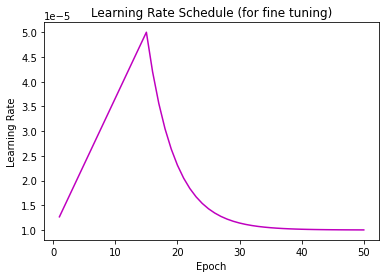

In [0]:
epx = range(1, epochs + 1)
lrs = [lr_schedule(e) for e in epx]

plt.plot(epx, lrs, 'm-')
plt.title("Learning Rate Schedule (for fine tuning)")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()

This model will be trained for a total of 50 epochs as data augmentation have been applied which will prevent the model to overfit. The model would benefit from being trained over a very large set of randomly generated / augmented images.

In [0]:
history = model.fit(
    resnet_aug_train_images, steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=resnet_val_images, 
    validation_steps=val_steps, callbacks=cbs)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/50
23/23 [==============================] - 15s 655ms/step - loss: 3.2670 - accuracy: 0.0905 - val_loss: 3.2892 - val_accuracy: 0.1063 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.2666666666666668e-05.
Epoch 2/50
23/23 [==============================] - 12s 501ms/step - loss: 2.4744 - accuracy: 0.2796 - val_loss: 2.4739 - val_accuracy: 0.2714 - lr: 1.2667e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 1.5333333333333334e-05.
Epoch 3/50
23/23 [==============================] - 11s 500ms/step - loss: 1.8016 - accuracy: 0.5143 - val_loss: 1.8146 - val_accuracy: 0.4254 - lr: 1.5333e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 4/50
23/23 [==============================] - 12s 504ms/step - loss: 1.2292 - accuracy: 0.6912 - val_loss: 1.2781 - val_accuracy: 0.5905 - lr: 1.8000e-05

Epoch 00005: LearningRateSchedul

In [0]:
class_labels = ['agricultural',
    'airplane',
    'baseballdiamond',
    'beach',
    'buildings',
    'chaparral',
    'denseresidential',
    'forest',
    'freeway',
    'golfcourse',
    'harbor',
    'intersection',
    'mediumresidential',
    'mobilehomepark',
    'overpass',
    'parkinglot',
    'river',
    'runway',
    'sparseresidential',
    'storagetanks',
    'tenniscourt']

The preprocessing applied to the data generator as a part of the model training pipeline uses ImageNet mean normalization in case of ResNet50. 

A few set images are to be visualized which would require that the mean normalization step as a part of pre-processing be rolled back.

In [0]:
def reverse_preprocess(x):
    mean = [103.939, 116.779, 123.68]
    x += mean # mean is added
    x = x[..., ::-1] # BGR to RGB

    # x is in range (0, 255.0)
    return x.astype(np.uint8)

We gather the last layer that preceeds the GAP layer in our model in order to use it for extracting convolutional features. Also, is extracted the weights of last dense layer of our model.

In [0]:
feature_layer = model.get_layer('resnet50')
pred_layer = model.layers[-1]

**Class Activation Maps**

Zhou, B., Khosla, A., Lapedriza, A., Oliva, A. and Torralba, A., 2016. Learning deep features for discriminative localization. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2921-2929).

Class activation maps could be used to intepret the prediction decision made by the CNN. It is generated using weights from the last dense layer used for making predictions for classification tasks on CNN and by utilizing the Global Average Pooling layer.

In [0]:
sample_images, sample_labels = next(resnet_val_images)

pred_probs = model.predict(sample_images)
features = feature_layer.predict(sample_images)

sample_images = reverse_preprocess(sample_images)
predicted_labels = np.argmax(pred_probs, axis=-1)

In [0]:
pred_weights = pred_layer.weights[0]
cams = (features @ pred_weights).numpy()

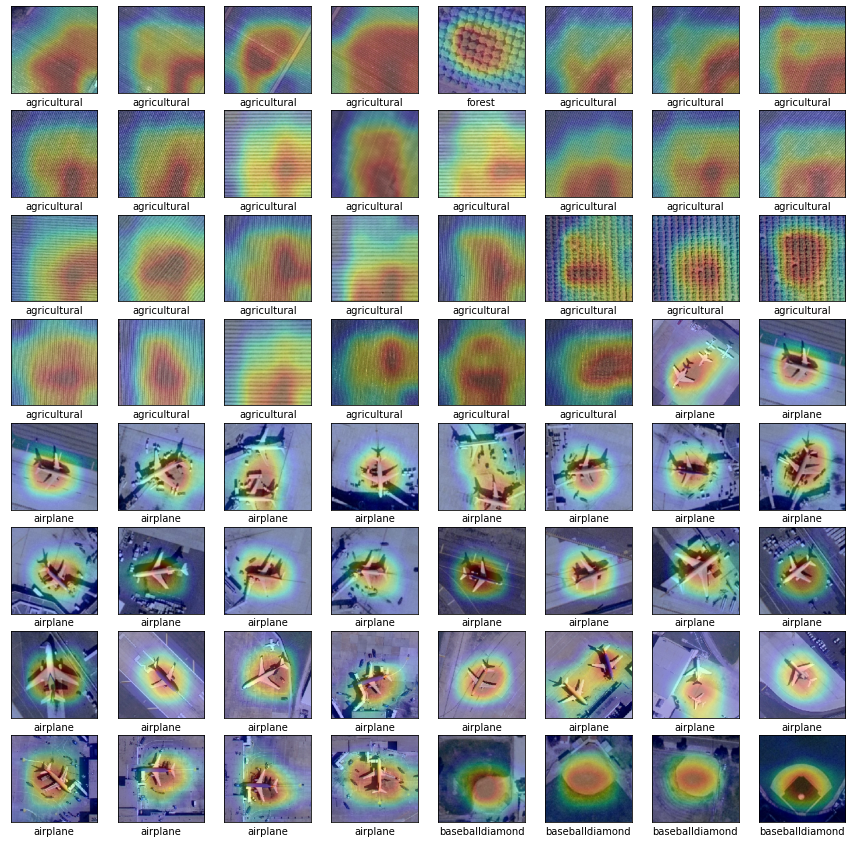

In [0]:
plt.figure(figsize=(15, 15))
for i in range(batch_size):
    plt.subplot(8, 8, i + 1)

    
    image = sample_images[i]
    label = predicted_labels[i]
    cam = cams[i, ..., label, None]

    cam_image = keras.preprocessing.image.array_to_img(cam / cam.max())
    cam_image = cam_image.resize(image_size)

    plt.imshow(image)
    plt.imshow(cam_image, alpha=0.3, cmap='jet')
    plt.xlabel(class_labels[label])

    plt.xticks([])
    plt.yticks([])

plt.show()